# Tesla Stock Forecasting with LSTM
> By: [Pedro Artur Varela](https://github.com/pedro-varela1)

The purpose of this notebook is to study the application of LSTM with PyTorch in Stock Forecasting. For this, we use the following database available on Kaggle: [Tesla Stock Price](https://www.kaggle.com/datasets/rpaguirre/tesla-stock-price). It contains the following data:
1. The date - "Date"
2. The opening price of the stock - "Open"
3. The high price of that day - "High"
4. The low price of that day - "Low"
5. The closed price of that day - "Close"
4. The amount of stocks traded during that day - "Volume"
5. The stock's closing price that has been amended to include any distributions/corporate actions that occurs before next days open - "Adj[usted] Close"

## Data Analyses and Preparation

### Data Visualization

In [1]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler      # For normalizing data
from copy import deepcopy       # To copy the data

# PyTorch libraries and modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader    # To create custom datasets

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Tesla.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [2]:
# New dataframe with date and close price
features = df[['Date', 'Close']]
features.head()

,Date,Close
0,6/29/2010,23.889999
1,6/30/2010,23.830000
2,7/1/2010,21.959999
3,7/2/2010,19.200001
4,7/6/2010,16.110001


In [3]:
# Check data info
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1692 non-null   object 
 1   Close   1692 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.6+ KB


In [4]:
# Check for missing values
features.isnull().sum()

Date     0
Close    0
dtype: int64

In [5]:
# Date is an object, convert to datetime
features['Date'] = pd.to_datetime(features['Date'])
features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1692 non-null   datetime64[ns]
 1   Close   1692 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.6 KB


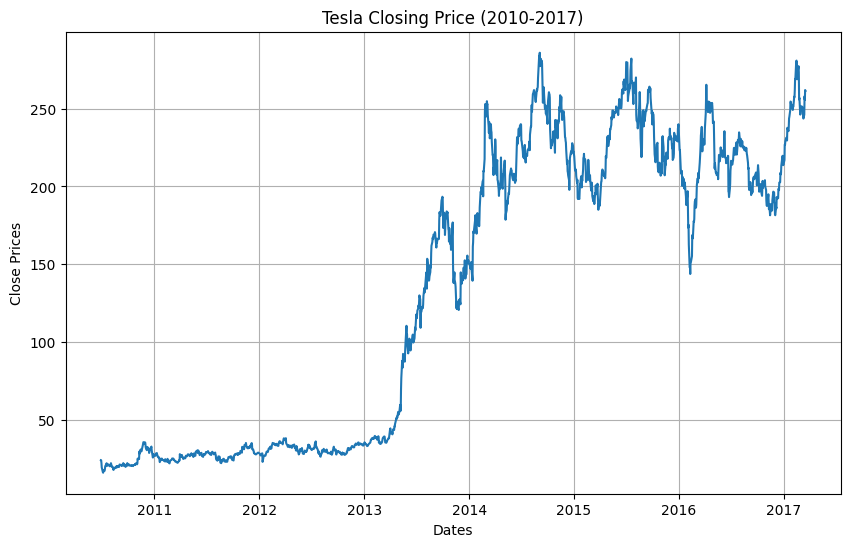

In [6]:
# Plot the data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(features['Date'], features['Close'])
plt.title('Tesla Closing Price (2010-2017)')
plt.show()

### Data Prepocessing

We've to prepare dato to lstm model.

The LSTM model will be trained on past 60 days data i.e. the model will try to predict the closing price based on the last 30 days.

In [7]:
# Prepare the data colecting the close prices of 'lookback' days

def prepare_data(df, lookback):
    data = deepcopy(df)
    data.set_index('Date', inplace=True)
    # Loop to create 'lookback' days lookback
    for i in range(1, lookback+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
    # Drop the NaN values (first 'lookback' days)
    data.dropna(inplace=True)
    return data

In [8]:
# Lets pass the function to the dataframe
# and check the result
lookback = 30
df_prepared = prepare_data(features, lookback)
df_prepared.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-21),Close(t-22),Close(t-23),Close(t-24),Close(t-25),Close(t-26),Close(t-27),Close(t-28),Close(t-29),Close(t-30)
Date,,,,,,,,,,,,,,,,,,,,,
2010-08-11,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,21.950001,20.920000,19.940001,20.350000,...,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001,19.200001,21.959999,23.830000,23.889999
2010-08-12,17.600000,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,21.950001,20.920000,19.940001,...,19.840000,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001,19.200001,21.959999,23.830000
2010-08-13,18.320000,17.600000,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,21.950001,20.920000,...,19.889999,19.840000,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001,19.200001,21.959999
2010-08-16,18.780001,18.320000,17.600000,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,21.950001,...,20.639999,19.889999,19.840000,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001,19.200001
2010-08-17,19.150000,18.780001,18.320000,17.600000,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,...,21.910000,20.639999,19.889999,19.840000,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001


It's time to split the data into train and test sets

In [9]:
# Split the data into train and test
# The train data will be from the first day to 2016-12-31
# The test data will be from 2017-01-01 to the last day

train = df_prepared[:'2016-12-31']
test = df_prepared['2017-01-01':]

# Check the shape of the data
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (1610, 31)
Test shape: (52, 31)


In [10]:
train.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-21),Close(t-22),Close(t-23),Close(t-24),Close(t-25),Close(t-26),Close(t-27),Close(t-28),Close(t-29),Close(t-30)
Date,,,,,,,,,,,,,,,,,,,,,
2010-08-11,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,21.950001,20.920000,19.940001,20.350000,...,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001,19.200001,21.959999,23.830000,23.889999
2010-08-12,17.600000,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,21.950001,20.920000,19.940001,...,19.840000,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001,19.200001,21.959999,23.830000
2010-08-13,18.320000,17.600000,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,21.950001,20.920000,...,19.889999,19.840000,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001,19.200001,21.959999
2010-08-16,18.780001,18.320000,17.600000,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,21.950001,...,20.639999,19.889999,19.840000,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001,19.200001
2010-08-17,19.150000,18.780001,18.320000,17.600000,17.900000,19.030001,19.600000,19.590000,20.450001,21.260000,...,21.910000,20.639999,19.889999,19.840000,18.139999,17.049999,17.400000,17.459999,15.800000,16.110001


In [11]:
test.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-21),Close(t-22),Close(t-23),Close(t-24),Close(t-25),Close(t-26),Close(t-27),Close(t-28),Close(t-29),Close(t-30)
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,216.990005,213.690002,214.679993,219.740005,219.529999,213.339996,208.449997,207.699997,208.789993,202.729996,...,181.880005,189.399994,189.570007,196.119995,196.649994,193.139999,191.169998,184.520004,185.020004,188.660004
2017-01-04,226.990005,216.990005,213.690002,214.679993,219.740005,219.529999,213.339996,208.449997,207.699997,208.789993,...,181.470001,181.880005,189.399994,189.570007,196.119995,196.649994,193.139999,191.169998,184.520004,185.020004
2017-01-05,226.750000,226.990005,216.990005,213.690002,214.679993,219.740005,219.529999,213.339996,208.449997,207.699997,...,186.800003,181.470001,181.880005,189.399994,189.570007,196.119995,196.649994,193.139999,191.169998,184.520004
2017-01-06,229.009995,226.750000,226.990005,216.990005,213.690002,214.679993,219.740005,219.529999,213.339996,208.449997,...,185.850006,186.800003,181.470001,181.880005,189.399994,189.570007,196.119995,196.649994,193.139999,191.169998
2017-01-09,231.279999,229.009995,226.750000,226.990005,216.990005,213.690002,214.679993,219.740005,219.529999,213.339996,...,193.149994,185.850006,186.800003,181.470001,181.880005,189.399994,189.570007,196.119995,196.649994,193.139999


The data shape has (train_rows+test_rows) 1662 rows, because for the first "lookback" days, we do not have the close price of the previous days (1692-30=1662) and 1 column for actual close and 30 for previous 30 closes.

In [12]:
test_np = test.to_numpy()
train_np = train.to_numpy()

# Apply MinMaxScaler to scale the data, i.e.,
# turn the data between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1))

# Fit the scaler to the data
train_scaled = scaler.fit_transform(train_np)
test_scaled = scaler.fit_transform(test_np)

# Check the shape of the data
print(f'Train shape: {train_scaled.shape}')
print(f'Test shape: {test_scaled.shape}')

Train shape: (1610, 31)
Test shape: (52, 31)


It's important to separate the features from the target variable. In this case, the target variable is the close price of the day. The features are the close prices of the previous days.

In [13]:
# Separate the features and the target
X_train = train_scaled[:, 1:]
y_train = train_scaled[:, 0]

X_test = test_scaled[:, 1:]
y_test = test_scaled[:, 0]

# Deepcopy to avoid problems in manipulation
X_train = deepcopy(np.flip(X_train, axis=1))
X_test = deepcopy(np.flip(X_test, axis=1))

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (1610, 30), y_train shape: (1610,)
X_test shape: (52, 30), y_test shape: (52,)


We can see that the a column of actual close prices was removed from the features and stored in the target variable.

Now, let's pass to torch tensors and reshape the data to be in the format (batch_size, sequence_length, input_size).

In [14]:
# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Pass the data to torch
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')


X_train shape: torch.Size([1610, 30, 1]), y_train shape: torch.Size([1610, 1])
X_test shape: torch.Size([52, 30, 1]), y_test shape: torch.Size([52, 1])


## Load Model

In [15]:
# Create a custom dataset for train and test
class TimeSeriesDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
# Dataloader
train_batch_size = 64
test_batch_size = 16

train_loader = DataLoader(dataset=train_dataset,
                            batch_size=train_batch_size,
                            shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                            batch_size=test_batch_size,
                            shuffle=False)

# Check the data
for _, (features1, target1) in enumerate(train_loader):
    print(features1.shape)
    print(target1.shape)
    break

torch.Size([64, 30, 1])
torch.Size([64, 1])


Looks good! Now, let's load the model from _model.py_ to device.

In [17]:
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
from model import LSTM
model = LSTM(input_size=1, hidden_size=128, num_layers=1, output_size=1, device=device)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## Train Model

### Preparation

Before training, we need to define a test function to evaluate the model.

In [19]:
# Test the model
def test(model, test_loader, criterion, device):
    model.eval()
    loss_test = 0.0
    for _, (X_test, y_test) in enumerate(test_loader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        with torch.no_grad():
            y_hat = model(X_test)
            loss = criterion(y_hat, y_test)
            loss_test += loss.item()
    
    avg_loss = loss_test / len(test_loader)
    return avg_loss

Let's define some training parameters.

In [20]:
# Parameters
num_epochs = 50
learning_rate = 0.0005
test_every = 12
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

Finally the training loop.

In [21]:
# Train
loss_train = []
loss_test = []
loss_train_epoch = 0.0
count_batch = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for _, (feature_train, target_train) in enumerate(train_loader):
        feature_train, target_train = feature_train.to(device), target_train.to(device)
        out = model(feature_train)
        loss = criterion(out, target_train)
        loss_train_epoch += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Test the model
        if count_batch % test_every == test_every-1:
            avg_loss_train = loss_train_epoch / test_every
            loss_train.append(avg_loss_train)
            avg_loss_test = test(model, test_loader, criterion, device)
            loss_test.append(avg_loss_test)
            print('Batch {0}, Actual Training Loss: {1:.4f}, Test Loss: {2:.4f}'.format(count_batch+1,
                                                                                        avg_loss_train,
                                                                                        avg_loss_test))
            loss_train_epoch = 0.0
            model.train()
        count_batch += 1
    print()

Epoch 1/50
Batch 12, Actual Training Loss: 0.4359, Test Loss: 0.2076
Batch 24, Actual Training Loss: 0.3223, Test Loss: 0.1854

Epoch 2/50
Batch 36, Actual Training Loss: 0.1166, Test Loss: 0.0717
Batch 48, Actual Training Loss: 0.0187, Test Loss: 0.0731

Epoch 3/50
Batch 60, Actual Training Loss: 0.0107, Test Loss: 0.0701
Batch 72, Actual Training Loss: 0.0080, Test Loss: 0.0773

Epoch 4/50
Batch 84, Actual Training Loss: 0.0074, Test Loss: 0.0735
Batch 96, Actual Training Loss: 0.0062, Test Loss: 0.0801

Epoch 5/50
Batch 108, Actual Training Loss: 0.0054, Test Loss: 0.0792
Batch 120, Actual Training Loss: 0.0060, Test Loss: 0.0813

Epoch 6/50
Batch 132, Actual Training Loss: 0.0052, Test Loss: 0.0794
Batch 144, Actual Training Loss: 0.0056, Test Loss: 0.0815
Batch 156, Actual Training Loss: 0.0049, Test Loss: 0.0789

Epoch 7/50
Batch 168, Actual Training Loss: 0.0053, Test Loss: 0.0796
Batch 180, Actual Training Loss: 0.0047, Test Loss: 0.0777

Epoch 8/50
Batch 192, Actual Training L

### Results

Let's check the loss evolution

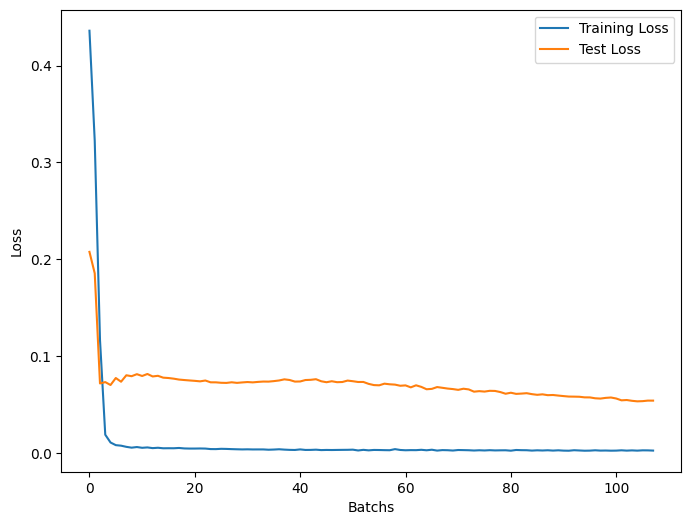

In [22]:
# Plot the loss
plt.figure(figsize=(8,6))
plt.xlabel('Batchs')
plt.ylabel('Loss')
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_test, label='Test Loss')
plt.legend(loc='upper right')
plt.show()

Let's check the behavior of the training predictions

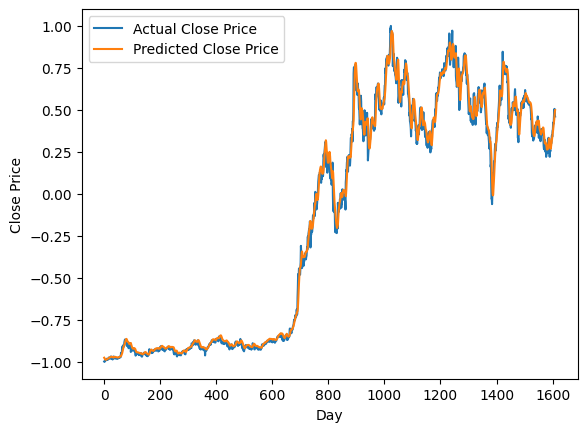

In [23]:
with torch.no_grad():
    predictions = model(X_train.to(device)).cpu().numpy()

# Plot the predictions
plt.plot(y_train.cpu().numpy(), label='Actual Close Price')
plt.plot(predictions, label='Predicted Close Price')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.show()

 It looks good for the training data, but what about the test data? Let's check it out.

## Test Visualization

Inverse transformation with train predictions.

In [24]:
# Inverse transform the data
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Create dummy array to inverse transform
# The dummy array is necessary because the scaler.inverse_transform
# only works with 2D arrays
dummy = np.zeros((test_predictions.shape[0], lookback+1))
dummy[:, 0] = test_predictions
dummy = scaler.inverse_transform(dummy)

test_predictions = deepcopy(dummy[:, 0])
print(test_predictions.shape)

(52,)


Inverse transformation with actual labels

In [25]:
dummy = np.zeros((y_test.shape[0], lookback+1))
dummy[:, 0] = y_test.flatten()
dummy = scaler.inverse_transform(dummy)

actual_targets = deepcopy(dummy[:, 0])
print(actual_targets.shape)

(52,)


Let's plot the predictions and the actual targets.

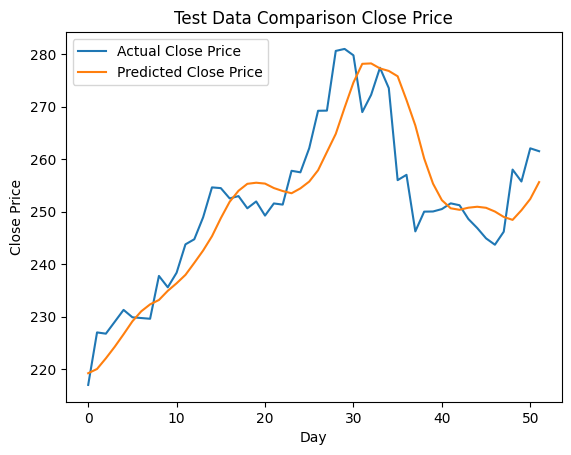

In [26]:
plt.plot(actual_targets, label='Actual Close Price')
plt.plot(test_predictions, label='Predicted Close Price')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.title('Test Data Comparison Close Price')
plt.show()

We can see that the model get the trend of the data. It's a good model to get a big picture. We can try to improve the model by changing the hyperparameters, adding more layers, etc.